# 4) Phrase Diversity (n-gram TTR)

This notebook is part of **Applied NLP – Session 2: Phrases & Collocations**.

Overview:
- Measure phrase diversity using Type-Token Ratio (TTR) for bigrams and trigrams.
- Compare lexical variety across two works by the same author.
- (Optional) Analyze diversity trends across sections/chapters within the texts.

Learning objectives:
- Understand and compute Type-Token Ratio (TTR) as a measure of lexical/phrasal diversity.
- Apply TTR to n-grams (bigrams, trigrams) to quantify phrase variety.
- Interpret TTR values: lower TTR suggests formulaic/repetitive phrasing, higher TTR indicates more varied expression.
- Produce reproducible diversity metrics and visualizations for literary analysis.

Quick start:
1. Edit the `CONFIG` dictionary in the next code cell to point to your two plain-text books.
2. (Optional) Toggle `use_stopwords` to exclude common function words.
3. Run cells from top to bottom. The main outputs are saved to `../results/`.
4. (Optional) Customize section-splitting regex to analyze diversity by chapter.

Prerequisites:
- A Python environment with requirements.txt packages installed (pandas, matplotlib).
- The text files for the two works placed in `../data/`.

Notes and tips:
- The notebook uses the same robust preprocessing as notebooks 1-2 (strip_gutenberg, normalize quotes, etc.).
- TTR formula: (unique n-grams) / (total n-grams). Values range from 0 to 1.
- Lower TTR: more repetition (e.g., epic poetry with formulaic epithets like "wine-dark sea").
- Higher TTR: more varied phrasing (e.g., experimental modernist prose).
- Section-wise analysis (optional cell) helps identify where diversity changes within a work.
- Compare TTR between your two books to see if the author's style evolved or differs by genre.
- Stopword removal may artificially inflate TTR by reducing common bigrams like "of the" or "in the".

**Goal:** Apply Type-Token Ratio (TTR) to bigrams and trigrams to measure phrase diversity in your two selected works.


## 0. Setup & Configuration

- Fill the `CONFIG` paths for your two books (plain text).
- Toggle stopwords and thresholds as needed.


In [1]:
# ===== Imports & Config =====
import re, os, math, json, collections
from pathlib import Path
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (9, 4.5)
plt.rcParams["axes.grid"] = True

CONFIG = {
    "book1_path": "..\\data\\Fellowship.txt",
    "book2_path": "..\\data\\TwoTowers.txt",
    "book3_path": "..\\data\\TheKing.txt",
    "language": "en",                # e.g. 'en','de','ru','el'
    "use_stopwords": False,          # toggle
    "min_ngram_count": 5,            # threshold (where applicable)
    "top_k": 20                      # top items to show
}

# Unicode-aware token regex: words with optional internal ' or -
WORD_RE = re.compile(r"[^\W\d_]+(?:[-'][^\W\d_]+)*", flags=re.UNICODE)

# Optional: supply your own stopwords set per language
STOPWORDS = set()


## 1. Load & Normalize Text

- Fix hyphenated line breaks (e.g., end-of-line hyphens).
- Normalize whitespace.
- Lowercase consistently.

Our books are a part of Project Gutenberg, which means there are some extra texts in each txt file to be cleaned.

In [2]:
# --- Robust Project Gutenberg boilerplate stripper --------------------------
_GB_START_MARKERS = [
    r"\*\*\*\s*START OF (THIS|THE) PROJECT GUTENBERG EBOOK",   # modern
    r"START OF (THIS|THE) PROJECT GUTENBERG EBOOK",             # fallback
    r"End of the Project Gutenberg(?:'s)? Etext",               # very old variants sometimes inverted
]
_GB_END_MARKERS = [
    r"\*\*\*\s*END OF (THIS|THE) PROJECT GUTENBERG EBOOK",      # modern
    r"END OF (THIS|THE) PROJECT GUTENBERG EBOOK",                # fallback
    r"End of Project Gutenberg(?:'s)? (?:Etext|eBook)",          # older variants
    r"\*\*\*\s*END: FULL LICENSE\s*\*\*\*",                      # license block end (older)
]

# Chapters (heuristic fallback if markers missing; English-centric but works often)
_CHAPTER_HINTS = [
    r"^\s*chapter\s+[ivxlcdm0-9]+[\.\: ]",   # CHAPTER I / Chapter 1
    r"^\s*book\s+[ivxlcdm0-9]+[\.\: ]",      # BOOK I etc.
    r"^\s*part\s+[ivxlcdm0-9]+[\.\: ]",
]

def strip_gutenberg(text: str) -> str:
    """
    Returns text between Gutenberg START and END markers (case-insensitive).
    If markers aren't found, heuristically trims to first chapter-like heading.
    Works for most EN/DE/RU/EL releases since headers are in English.
    """
    t = text.replace("\ufeff", "")  # strip BOM if present

    # Find START
    start_idx = None
    for pat in _GB_START_MARKERS:
        m = re.search(pat, t, flags=re.IGNORECASE)
        if m:
            # start AFTER the matched line
            start_idx = t.find("\n", m.end())
            if start_idx == -1:
                start_idx = m.end()
            break

    # Find END
    end_idx = None
    for pat in _GB_END_MARKERS:
        m = re.search(pat, t, flags=re.IGNORECASE)
        if m:
            # end BEFORE the matched line
            end_idx = m.start()
            break

    if start_idx is not None and end_idx is not None and end_idx > start_idx:
        core = t[start_idx:end_idx]
    else:
        # Fallback: try to start at first chapter-like heading
        core = t
        for pat in _CHAPTER_HINTS:
            m = re.search(pat, core, flags=re.IGNORECASE | re.MULTILINE)
            if m:
                core = core[m.start():]
                break
        # And trim off the standard license tail if present
        for pat in _GB_END_MARKERS:
            m = re.search(pat, core, flags=re.IGNORECASE)
            if m:
                core = core[:m.start()]
                break

    # Remove license/contact blocks that sometimes sneak inside
    core = re.sub(r"\n\s*End of the Project Gutenberg.*", "", core, flags=re.IGNORECASE)
    core = re.sub(r"\*\*\*\s*START: FULL LICENSE\s*\*\*\*.*", "", core, flags=re.IGNORECASE | re.DOTALL)

    # Clean leftover cruft: URLs, repeated separators
    core = re.sub(r"https?://\S+", "", core)
    core = re.sub(r"[ \t]+\n", "\n", core)   # trailing spaces before newline
    core = re.sub(r"\n{3,}", "\n\n", core)   # collapse big blank blocks
    return core.strip()


In [3]:
def load_text(p: str) -> str:
    with open(p, "r", encoding="utf-8", errors="ignore") as f:
        return f.read()

def normalize_text(t: str) -> str:
    # 1) strip Gutenberg header/footer FIRST
    t = strip_gutenberg(t)
    # 2) join hyphenated line breaks (e.g., "won-\nderful")
    t = re.sub(r"-\s*\n", "", t)
    # 3) normalize whitespace
    t = re.sub(r"\s+", " ", t)
    return t

text1 = normalize_text(load_text(CONFIG["book1_path"]))
text2 = normalize_text(load_text(CONFIG["book2_path"]))
text3 = normalize_text(load_text(CONFIG["book3_path"]))

tokens1 = WORD_RE.findall(text1.lower())
tokens2 = WORD_RE.findall(text2.lower())
tokens3 = WORD_RE.findall(text3.lower())

if CONFIG["use_stopwords"]:
    tokens1 = [t for t in tokens1 if t not in STOPWORDS]
    tokens2 = [t for t in tokens2 if t not in STOPWORDS]
    tokens3 = [t for t in tokens3 if t not in STOPWORDS]

tokens = tokens1 + tokens2 + tokens3

len(tokens1), len(tokens2), len(tokens)

len(tokens), tokens[:12]


(477524,
 ['john',
  'r',
  'r',
  'tolkien',
  'fellowship',
  'of',
  'the',
  'ring',
  'foreword',
  'this',
  'tale',
  'grew'])

## 2. Compute TTR for Bigrams & Trigrams

Type–Token Ratio for n-grams measures phrase variety.

$$\text{TTR}(S) = \frac{|\text{unique n-grams}|}{|\text{total n-grams}|}$$

In [4]:
def ttr(seq):
    return len(set(seq)) / max(1, len(seq))

# Combined corpus TTR
bigrams_list = list(zip(tokens, tokens[1:]))
trigrams_list = list(zip(tokens, tokens[1:], tokens[2:]))

ttr2_combined = ttr(bigrams_list)
ttr3_combined = ttr(trigrams_list)

# Book 1 TTR
bigrams_list_1 = list(zip(tokens1, tokens1[1:]))
trigrams_list_1 = list(zip(tokens1, tokens1[1:], tokens1[2:]))

ttr2_book1 = ttr(bigrams_list_1)
ttr3_book1 = ttr(trigrams_list_1)

# Book 2 TTR
bigrams_list_2 = list(zip(tokens2, tokens2[1:]))
trigrams_list_2 = list(zip(tokens2, tokens2[1:], tokens2[2:]))

ttr2_book2 = ttr(bigrams_list_2)
ttr3_book2 = ttr(trigrams_list_2)

# Book 3 TTR
bigrams_list_3 = list(zip(tokens3, tokens3[1:]))
trigrams_list_3 = list(zip(tokens3, tokens3[1:], tokens3[2:]))

ttr2_book3 = ttr(bigrams_list_3)
ttr3_book3 = ttr(trigrams_list_3)

# Create comparison DataFrame
summary_df = pd.DataFrame({
    "metric": ["bigram_TTR", "trigram_TTR"],
    "book1": [ttr2_book1, ttr3_book1],
    "book2": [ttr2_book2, ttr3_book2],
    "book3": [ttr2_book3, ttr3_book3],
    "combined": [ttr2_combined, ttr3_combined]
})
summary_df

,metric,book1,book2,book3,combined
0,bigram_TTR,0.435438,0.465529,0.454175,0.347133
1,trigram_TTR,0.829123,0.853617,0.844341,0.766905


## 2.1 Visualize TTR Comparison

Compare bigram and trigram diversity visually.

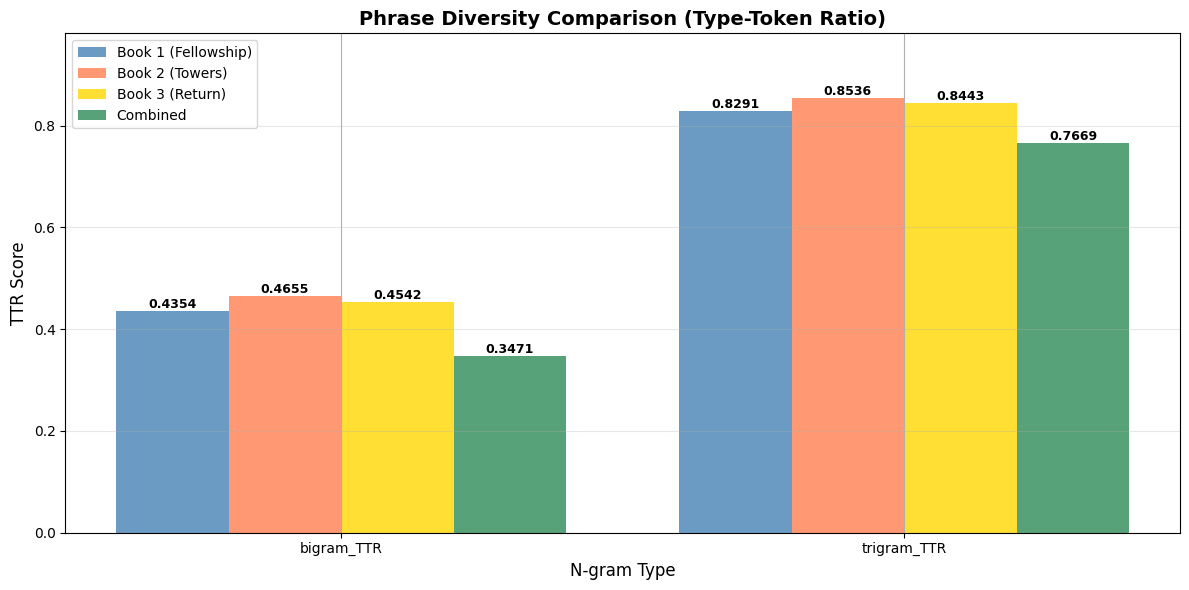

In [7]:
import numpy as np

fig_ttr, ax = plt.subplots(figsize=(12, 6))

# Set up grouped bar chart
x = np.arange(len(summary_df["metric"]))
width = 0.2  # Made narrower to fit 4 bars

# Create bars for each book
# We center the group of 4 bars around 'x'
bars1 = ax.bar(x - 1.5*width, summary_df["book1"], width, label='Book 1 (Fellowship)', color='steelblue', alpha=0.8)
bars2 = ax.bar(x - 0.5*width, summary_df["book2"], width, label='Book 2 (Towers)', color='coral', alpha=0.8)
bars3 = ax.bar(x + 0.5*width, summary_df["book3"], width, label='Book 3 (Return)', color='gold', alpha=0.8)
bars4 = ax.bar(x + 1.5*width, summary_df["combined"], width, label='Combined', color='seagreen', alpha=0.8)

# Customize plot
ax.set_ylabel("TTR Score", fontsize=12)
ax.set_xlabel("N-gram Type", fontsize=12)
ax.set_title("Phrase Diversity Comparison (Type-Token Ratio)", fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(summary_df["metric"])
ax.legend(fontsize=10)

# --- FIX IS HERE: Removed the extra max() wrapper ---
ax.set_ylim(0, summary_df[["book1", "book2", "book3", "combined"]].max().max() * 1.15)

ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

## 3. (Optional) Section-wise Diversity

If chapters/sections are detectable by regex, estimate diversity per section.


In [ ]:
# # naive split by keywords; customize per book
# sections = re.split(r"\bchapter\b|\bbook\b|\bpart\b", full_text, flags=re.IGNORECASE)
# rows = []
# for i, sec in enumerate(sections, start=1):
#     toks = WORD_RE.findall(sec.lower())
#     b2 = list(zip(toks, toks[1:]))
#     b3 = list(zip(toks, toks[1:], toks[2:]))
#     rows.append({"section": i, "bigram_TTR": ttr(b2), "trigram_TTR": ttr(b3)})
# sec_df = pd.DataFrame(rows)

# ax = sec_df.plot(x="section", y=["bigram_TTR","trigram_TTR"])
# ax.set_title("Phrase Diversity by Section (proxy)")
# ax.set_xlabel("Section index")
# ax.set_ylabel("TTR")
# plt.tight_layout(); plt.show()

## 4. Notes

- Lower TTR suggests more formulaic phrasing (e.g., epic epithets).
- Compare the two works separately if you can split cleanly.


## 5. Reflection (Answer in your repo's README or below)

- Which results matched your reading intuition?
- What surprised you?
- If you toggled preprocessing (stopwords on/off), what changed?
- Compare across the two works: are the patterns stable?

## 6. Export (tables/figures)

This cell saves outputs into the `../results/` folder so you can add them to your report.


In [ ]:
Path("../results").mkdir(exist_ok=True)

# Save CSV table
summary_df.to_csv("../results/TTR_table.csv", index=False)

# Save figure explicitly by referencing the Figure object we created earlier
try:
    fig_ttr.savefig("../results/TTR_figure.png", dpi=200, bbox_inches="tight")
    print("✓ Saved TTR_table.csv and TTR_figure.png to ../results/")
except NameError:
    # fig_ttr not defined (visualization cell may not have been executed)
    print("⚠ Figure not saved - run the visualization cell first")
    try:
        plt.savefig("../results/TTR_figure.png", dpi=200, bbox_inches="tight")
    except Exception:
        pass